# ROBPCA: A New Approach to Robust Principal Component Analysis
===
Group 15
---
> Honor Code: We shall be honest in our efforts and will make our parents proud.


Shikha Bhat (2019A7PS0063G)

Yash Trivedi (2019B4AA0834G)

Viraj Sharma(2020A7PS1011G)

ROBPCA is a 'ROBust method for Principal Components Analysis'. It is resistant to outliers in the data. The robust loadings are computed using projection-pursuit techniques and the MCD method. 
Therefore ROBPCA can be applied to both low and high-dimensional data sets.
In low dimensions, the MCD method is applied.
The ROBPCA method is described in Hubert, M., Rousseeuw, P.J., Vanden Branden, K. (2005), ROBPCA: a new approach to robust principal components analysis, Technometrics, 47, 64-79.

## Motivation

While solving any ML problem, the data that we use to analyze and feed to the model is of great importance. Principal Component Analysis is widely used for the analysis of high-dimensional data, and allows us to represent the dataset as linear combinations of the original variables in a lower dimension. 

PCA often allows for interpretation and better understanding of the different sources of variation. However, the classic approach to PCA is sensitive to outliers (very high or low observations), because it is dependent on the variance-covariance matrix. The first principal component of a set of p variables is the derived variable formed as a linear combination of the original variables that explains the **most** variance. 

Outliers increase the variance of the data. The principal components may then be distorted so as to fit the outlier, which leads to a bad interpretation of the results. Thus, the authors of this paper aim to introduce a new, robust method of PCA, which can address this problem. They call it ROBPCA.

## Problem Definition

1. To develop a robust method through which we can accurately apply PCA to high dimensional data having outliers 
2. Using this robust PCA, get a diagnostic plot that can be used to detect and classify  outliers.

## Methodology


We assume that the original data are stored in an n × p data matrix X where n denotes the number of objects and p denotes the original number of variables. 

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### Import Dataset
Our first example is the low-dimensional car dataset, which
is available in S–PLUS as the data frame cu.dimensions. For n = 111 cars, p = 11 characteristics were measured, including the length, width, and height of the car.

In [48]:
df = pd.read_excel("Octane.xlsx")
df.rename(columns = {'Unnamed: 0':'Name'}, inplace = True)

In [49]:
df.head()

,Sample name,Octane number,1100,1102,1104,1106,1108,1110,1112,1114,...,1532,1534,1536,1538,1540,1542,1544,1546,1548,1550
0,M01,88.600006,-0.001835,-0.001496,-0.001009,-0.000360,0.000466,0.001502,0.002798,0.004410,...,0.040192,0.038423,0.036768,0.035235,0.033835,0.032575,0.031462,0.030508,0.029727,0.029127
1,M02,88.800003,-0.001627,-0.001261,-0.000748,-0.000065,0.000818,0.001943,0.003354,0.005088,...,0.041009,0.039185,0.037459,0.035842,0.034354,0.033023,0.031876,0.030927,0.030179,0.029622
2,M05,89.400002,-0.000465,-0.000330,0.000181,0.001121,0.002465,0.004140,0.006075,0.008238,...,0.044729,0.043308,0.041914,0.040548,0.039222,0.037938,0.036706,0.035545,0.034493,0.033604
3,L06,86.700005,-0.001443,-0.001094,-0.000596,0.000082,0.000972,0.002114,0.003545,0.005299,...,0.045022,0.043128,0.041327,0.039629,0.038052,0.036621,0.035361,0.034299,0.033446,0.032808
4,H11,91.199997,-0.001607,-0.001155,-0.000548,0.000244,0.001259,0.002551,0.004177,0.006188,...,0.038111,0.036470,0.034925,0.033475,0.032138,0.030943,0.029920,0.029091,0.028468,0.028044


In [50]:
X = df.drop(['Sample name',	'Octane number'], axis=1)
print(len(X.columns))

226


In [51]:
n = X.shape[0]
p = X.shape[1]
print(n,p)

39 226


### Mean subtracted data
For PCA, we must first subtract the mean of each column from the datapoint in that column. This way, we center the data around 0.

In [52]:
# converting to numpy array for better handling
X_np = np.array(X)
print(X_np.shape)

(39, 226)


In [53]:
means = []
for i in range(len(X.columns)):
  means.append(X_np[:, i].mean())
mu0 = np.array(means)
mu0.resize((mu0.shape[0], 1)) #converting to p-variate column vector

## ROBPCA

### The ROBPCA Method
Previous efforts have been to replace the classical covariance matrix by robust covariance estimators but these cannot resist many outliers or are limited to small to moderate dimensions. Projection pursuit techniques have also been used in the past, which can handle higher dimensions. The ROBPCA method attempts to combine the advantages of both approaches - 
1. The projection pursuit technique is used for the initial dimension reduction of the data.
2. Some ideas based on the MCD estimator (minimum covariance determinant) are then applied to this lower-dimensional data space.

### Stage 1: Reducing to affine subspace using SVD
As proposed by Hubert et al. (2002), we start by reducing the data space to the affine subspace spanned by the n observations. This is especially useful when p ≥ n, but even
when p < n, the observations may span less than the whole p-dimensional space. A convenient way to do this is by a singular value decomposition of the mean-centered data matrix.


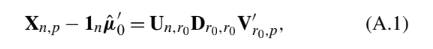

In [54]:
U, d, Vh = np.linalg.svd(X_np - np.ones((n,1))@mu0.T, full_matrices=False)
D = np.diag(d)

In [55]:
U.shape, D.shape, Vh.shape

((39, 39), (39, 39), (39, 226))

Without losing any information, we now work in the subspace spanned by the r0 columns of V. That is, Z = UD (n x r0) becomes our new data matrix.

In [56]:
Z = U@D
r0 = Z.shape[1]
print(Z.shape)

(39, 39)


Note that this singular value decomposition is just an affine transformation of the data. We do not use it to retain only the first eigenvectors of the covariance matrix of Xn,p; this would imply that we were performing CPCA, which is of course not robust. Here we merely represent the data in its own dimensionality.

### Stage 2: Preliminary subspace without outliers
In this stage we try to find the h < n “least outlying” data points. We then use their covariance matrix to obtain a preliminary subspace of dimension k0. The value of h can be chosen by the user, but n − h should exceed the number of outliers in the dataset.


Because we do not know the number of outliers or k0 at this moment, we take h = max{[αn], [(n + kmax + 1)/2]}, where kmax represents the maximal number of components that will be computed and is set to 10 by default.

The parameter α can be chosen as any real value between .5 and 1. The higher the α, the more efficient the estimates will be for uncontaminated data. But setting a lower value for α will increase the robustness of the algorithm for contaminated samples. Our default, which is also used in the simulations, is α = .75.

In [57]:
# default values
alpha = 0.75
kmax = 7
h = max(int(alpha * n), int((n + kmax + 1)/2))
print(h)

29


We compute the degree of outlyingness for all data points and consider the h observations with smallest outlyingness. Their indices are stored in the set H0.

In [58]:
from sklearn.neighbors import LocalOutlierFactor
from heapq import heappush, heappop

# calculating the outlyingness score
clf = LocalOutlierFactor(n_neighbors=250)
clf.fit(Z)
opp_outlyingness = clf.negative_outlier_factor_

# getting the h least scores and storing their indices in H0
scores_heap = []
for i in range(n):
  heappush(scores_heap, (-opp_outlyingness[i], i))

H0 = []
for i in range(h):
  temp = heappop(scores_heap)
  H0.append(temp[1])
  # print(temp[0])

print(H0)

[25, 33, 22, 5, 13, 14, 11, 4, 29, 6, 30, 9, 12, 21, 28, 10, 32, 0, 23, 19, 7, 1, 31, 20, 15, 17, 18, 8, 26]


/usr/local/lib/python3.8/dist-packages/sklearn/neighbors/_lof.py:284: UserWarning: n_neighbors (250) is greater than the total number of samples (39). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


In [59]:
# storing the observations with least outlyingness
reduced_data = [0 for i in range(h)]
for i in range(h):
  index = H0[i]
  reduced_data[i] = Z[index]
reduced_data = np.array(reduced_data)
reduced_data.shape

(29, 39)

 We now consider μ1 and S0, the mean and covariance matrix of the h observations in H0. We follow the convention that the eigenvalues of any scatter matrix are sorted in descending order and the eigenvectors are indexed accordingly. This means that the eigenvector v1 corresponds to the largest eigenvalue, v2 corresponds to the second
largest eigenvalue, and so on. The spectral decomposition
of S0 is denoted by

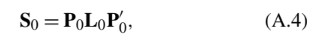

In [60]:
S0 = np.cov(reduced_data.T)

means = []
for i in range(reduced_data.shape[1]):
  means.append(reduced_data[:, i].mean())
mu1 = np.array(means)
mu1.resize((mu1.shape[0], 1)) #converting to p-variate column vector

In [61]:
S0.shape, mu1.shape

((39, 39), (39, 1))

In [62]:
eigenvalues, V = np.linalg.eigh(S0, UPLO='U')
eigenvalues # the eigenvalues are in ascending order

array([-1.90013167e-17, -5.60915275e-18, -1.16895764e-18, -3.66122726e-19,
       -1.00767117e-19,  2.44225111e-55,  1.54011908e-19,  6.37870674e-19,
        1.99433144e-18,  3.28457800e-18,  3.17723522e-17,  2.15444133e-09,
        3.19380320e-09,  6.26643966e-09,  6.96776634e-09,  9.14600851e-09,
        1.41162218e-08,  2.21544145e-08,  2.58569937e-08,  3.62533929e-08,
        4.03156603e-08,  5.43160548e-08,  6.56960396e-08,  9.57673849e-08,
        1.55557887e-07,  2.51556431e-07,  5.63540123e-07,  8.89712447e-07,
        2.08701451e-06,  2.70162325e-06,  3.40110996e-06,  7.10649262e-06,
        1.60044312e-05,  3.77793506e-05,  5.29568991e-05,  1.15396572e-04,
        1.76139493e-03,  9.21607028e-03,  6.77549419e-02])

In [63]:
l0 = np.flip(eigenvalues)
L0 = np.diag(l0)
P0 = np.flip(V, axis=1)

In [64]:
P0.shape, L0.shape

((39, 39), (39, 39))

The covariance matrix S0 is used to decide how many principal components k0 ≤ r will be retained in the further analysis. 

In [65]:
# selection criterion for k0
sum_ev = sum(l0)
sum_k = 0
k0 = 0
for ev in l0:
  sum_k += ev
  k0 += 1
  if sum_k >= 0.9*sum_ev:
    break
print(k0)

2


Finally, we project the data points on the subspace spanned by the first k0 eigenvectors of S0. To implement this step, we set

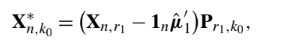

In [66]:
P_k0 = P0[:, :k0] # getting the first k0 vectors of P0
X_nk = (Z - np.ones((n,1))@mu1.T)@P_k0 # new data

In [67]:
P_k0.shape, X_nk.shape

((39, 2), (39, 2))

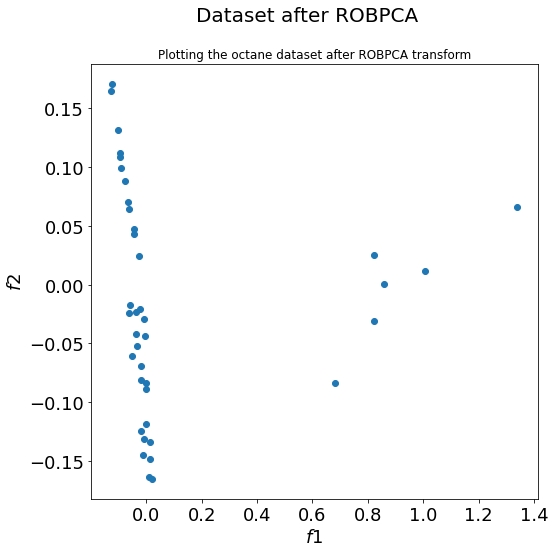

In [68]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Plot the dataset
plt.figure(figsize=(8,8))
pca_plot = plt.scatter(X_nk[:,0], X_nk[:,1])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('$f1$',fontsize=18)
plt.ylabel('$f2$',fontsize=18)
plt.suptitle('Dataset after ROBPCA',fontsize=20)
plt.title('Plotting the octane dataset after ROBPCA transform',fontsize=12)
plt.show( )

### Stage 3: Using MCD Estimator
In the third stage of the algorithm, we robustly estimate the scatter matrix of the data points in X (n x k0) using the MCD estimator. Recall that for this, we need to find h data points whose covariance matrix has minimal determinant. Because in general we cannot consider all h-subsets, we must rely on approximate algorithms.

In [69]:
from sklearn.covariance import MinCovDet

mcd = MinCovDet(random_state=42).fit(X_nk)
S4 = np.array(mcd.covariance_)
mu5 = np.array(mcd.location_)
mu5.resize((mu5.shape[0], 1)) #converting to p-variate column vector

In [70]:
S4.shape, mu5.shape

((2, 2), (2, 1))

The spectral decomposition of S4 can be written as
S4 = P2@L2@P2h, where the columns of P2 contain the eigenvectors of S4 and L2 is the diagonal matrix with the corresponding eigenvalues.

In [71]:
eigenvalues, V = np.linalg.eigh(S4, UPLO='U')
eigenvalues # the eigenvalues are in ascending order

array([0.00020404, 0.00668975])

In [72]:
l2 = np.flip(eigenvalues)
L2 = np.diag(l2)
P2 = np.flip(V, axis=1)

In [73]:
P2.shape, L2.shape

((2, 2), (2, 2))

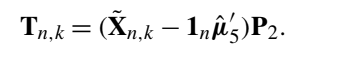

In [74]:
T = (X_nk - np.ones((n,1))@mu5.T)@P2 #scores

### Diagnostic Plots (Outlier Maps)

Diagnostic plots help in distinguishing between regular observations and three types of outliers - orthogonal outliers, good leverage points and bad levarage points by plotting the orthogonal distance of the outliers from the PCA subspace vs the robust score distance of the observations.

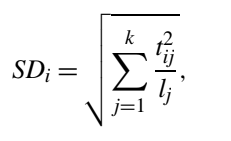

In [75]:
import math

SD_ROBPCA = [0 for i in range(T.shape[0])]
for i in range(T.shape[0]):
  temp = 0
  for j in range(T.shape[1]):
    temp += (math.pow(T[i][j], 2)/l2[j])
  SD_ROBPCA[i] = math.sqrt(temp)

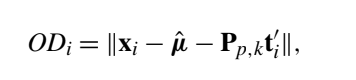

In [76]:
OD_ROBPCA = [0 for i in range(T.shape[0])]
mu_hat = np.ones((n,1))@mu1.T
for i in range(n):
  OD_ROBPCA[i] = np.linalg.norm((Z[i].T - mu_hat[i].T) - P_k0@(T[i].T))

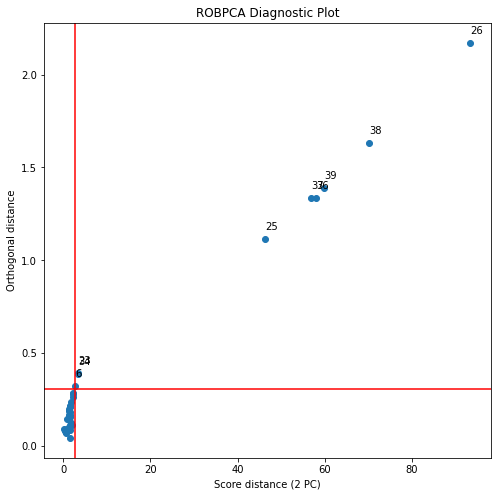

In [77]:
import matplotlib.pyplot as plt
from scipy.stats import chi2

# plotting a line plot after changing it's width and height
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

# calculating cutoff values
cutoff_x = math.sqrt(chi2.isf(df=k0, q=0.025))
plt.axvline(x = cutoff_x, color = 'r', label = 'axvline - full height')

OD = np.array(OD_ROBPCA).T
OD = OD.reshape(-1,1)
cov = MinCovDet(random_state=42).fit(OD**(2/3))
# print(cov.location_, cov.covariance_[0][0])
cutoff_y = math.pow(cov.location_[0] + math.sqrt(cov.covariance_[0][0]) * 1.96, 3/2)
plt.axhline(y = cutoff_y, color = 'r', label = 'axhline - full width')


plt.scatter(SD_ROBPCA, OD_ROBPCA)
for i in range(n):
  if SD_ROBPCA[i] > cutoff_x or OD_ROBPCA[i] > cutoff_y:
    plt.text(SD_ROBPCA[i]+0.05, OD_ROBPCA[i]+0.05, str(i+1))

# naming the x and y axis
plt.xlabel("Score distance ("+str(k0)+" PC)")
plt.ylabel('Orthogonal distance')
# plt.xlim(xmin=0, xmax=100)
# plt.ylim(ymin=0, ymax=2.5)
plt.title('ROBPCA Diagnostic Plot')
plt.show()

## Classical PCA

In [78]:
X_ms = X_np - np.ones((n,1))@mu0.T

### Variance-Covariance Matrix
 
In order to identify the correlations between the features of the dataset, we compute the covariance matrix of the mean subtracted data.

In [79]:
# find the variance-covariance matrix of the mean subtracted data.
def varianceCovariance(data): 
    dim = len(data)
    return 1/(dim-1) * np.dot(np.transpose(data), data)

cov_matrix = varianceCovariance(X_ms)

### Eigenvalue Decomposition
Principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated. As the next step, we have to find the eigenvalue decomposition of variance-covariance matrix obtained above.

In [80]:
#getting the eigenvalues and eigenvector V of the covariance matrix obtained above
eigenvalues, V = np.linalg.eigh(cov_matrix, UPLO='U')
# getting V inverse
V_inv = np.linalg.inv(V)
# getting eigenvalues matrix
Λ = np.diag(eigenvalues)

### Feature Vector
We saw above that the eigenvectors are obtained in the ascending order (i.e., the eigenvector corresponding to minimum eigenvalue is the first column, followed by second and so on). 

In [81]:
eigenvalues

array([-1.71985673e-17, -8.67190872e-18, -6.74003540e-18, -6.36379648e-18,
       -5.88632102e-18, -5.12386679e-18, -4.39105259e-18, -4.26238462e-18,
       -4.03295004e-18, -3.83650206e-18, -3.55615892e-18, -3.51774461e-18,
       -3.23622829e-18, -3.20915645e-18, -2.79689873e-18, -2.51976070e-18,
       -2.30109583e-18, -2.18867835e-18, -1.94531527e-18, -1.93167511e-18,
       -1.74135128e-18, -1.53387513e-18, -1.32033009e-18, -1.19491616e-18,
       -1.13676452e-18, -1.07085112e-18, -1.02873812e-18, -7.44554020e-19,
       -7.40009055e-19, -6.93429495e-19, -6.81787204e-19, -5.09094638e-19,
       -4.73673325e-19, -3.92674914e-19, -3.64964575e-19, -3.60795668e-19,
       -3.38524964e-19, -2.91004413e-19, -2.60492784e-19, -2.30596404e-19,
       -2.20563682e-19, -2.08411864e-19, -1.71279881e-19, -1.67520531e-19,
       -1.48322867e-19, -1.44334317e-19, -1.22148093e-19, -1.20649357e-19,
       -1.18510774e-19, -1.08471966e-19, -9.16331772e-20, -9.13212661e-20,
       -8.84897705e-20, -

Computing the eigenvectors and ordering them by their eigenvalues in _descending_ order allow us to find the principal components in order of significance. Thus we will first flip the obtained eigenvectors matrix along the columns, and then we choose the first 2 components (eigenvectors) of maximum significance to form the feature vector. This makes PCA a dimensionality reduction technique as the final data set will have only 4 dimensions.

In [82]:
V_reverse = np.flip(V, axis=1)
eigen_reverse = np.flip(eigenvalues)

In [83]:
feature_vector = V_reverse[:,:k0]
feature_vector

array([[-2.71056749e-03,  1.13203983e-03],
       [-2.71771357e-03,  6.79282535e-04],
       [-2.73212558e-03,  1.92784197e-04],
       [-2.75579906e-03, -3.37016662e-04],
       [-2.78820116e-03, -9.30944388e-04],
       [-2.82852925e-03, -1.63390527e-03],
       [-2.87693441e-03, -2.52039171e-03],
       [-2.93642992e-03, -3.68858590e-03],
       [-3.01241848e-03, -5.24586009e-03],
       [-3.10920546e-03, -7.36860316e-03],
       [-3.22883008e-03, -1.02191869e-02],
       [-3.36853069e-03, -1.39333933e-02],
       [-3.52290781e-03, -1.86801711e-02],
       [-3.68677431e-03, -2.46797580e-02],
       [-3.86178558e-03, -3.22035211e-02],
       [-4.06180324e-03, -4.15361585e-02],
       [-4.30762990e-03, -5.29269260e-02],
       [-4.62576967e-03, -6.64570177e-02],
       [-5.04303520e-03, -8.17301018e-02],
       [-5.57718180e-03, -9.77978345e-02],
       [-6.22984152e-03, -1.13182756e-01],
       [-6.98940572e-03, -1.26055168e-01],
       [-7.82924349e-03, -1.34625693e-01],
       [-8.

#### Principal Components
We then use the feature vector formed using the eigenvectors of the covariance matrix, to reorient the data from the original axes to the ones represented by the principal components. This can be done by multiplying the transpose of the mean subtracted data set by the transpose of the feature vector. This gives us the PCA data set, with data items in columns, and dimensions along rows. Its transpose will give us the final new dataset.

In [84]:
X_PCA = np.transpose(np.dot(np.transpose(feature_vector), np.transpose(X_ms)))
X_PCA

array([[-1.44400653e-01,  3.42504396e-02],
       [-1.27913299e-01,  6.40196272e-02],
       [-1.13502785e-01,  2.66465189e-02],
       [-9.55849303e-02,  1.17284728e-01],
       [-1.83858017e-01, -1.05503903e-01],
       [-2.12556139e-01, -1.47643943e-01],
       [-1.71294686e-01,  7.24556207e-03],
       [-1.21578406e-01,  1.27991087e-01],
       [-1.00925500e-01,  1.46467857e-01],
       [-1.69842332e-01, -8.17871583e-02],
       [-1.47843716e-01,  2.47556188e-02],
       [-1.99574676e-01, -1.17199854e-01],
       [-1.61565990e-01,  4.39365765e-02],
       [-2.03977444e-01, -1.28585234e-01],
       [-2.03793352e-01, -1.26352109e-01],
       [-1.18002517e-01,  1.14697717e-01],
       [-9.61025039e-02,  1.31537582e-01],
       [-1.18439041e-01,  1.09480675e-02],
       [-1.12694276e-01,  1.01710784e-01],
       [-1.34316631e-01, -4.19434765e-02],
       [-1.28521738e-01,  5.23473964e-02],
       [-1.54010289e-01, -6.56880785e-02],
       [-2.32529212e-01, -1.87654838e-01],
       [-1.

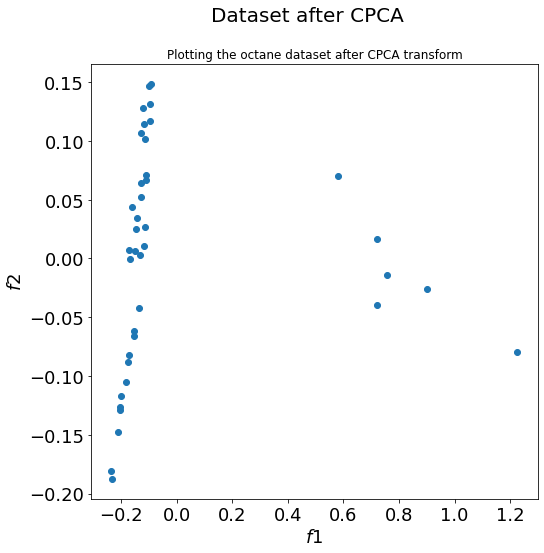

In [85]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Plot the dataset
plt.figure(figsize=(8,8))
pca_plot = plt.scatter(X_PCA[:,0], X_PCA[:,1])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('$f1$',fontsize=18)
plt.ylabel('$f2$',fontsize=18)
plt.suptitle('Dataset after CPCA',fontsize=20)
plt.title('Plotting the octane dataset after CPCA transform',fontsize=12)
plt.show( )

In [86]:
T = X_ms@feature_vector

### Diagnostic Plots

In [87]:
import math

SD_CPCA = [0 for i in range(T.shape[0])]

for i in range(T.shape[0]):
  temp = 0
  for j in range(T.shape[1]):
    temp += (T[i][j] ** 2)/eigen_reverse[j]
  SD_CPCA[i] = math.sqrt(temp)

In [88]:
OD_CPCA = [0 for i in range(T.shape[0])]
mu_hat = np.ones((n,1))@mu0.T
for i in range(n):
  OD_CPCA[i] = np.linalg.norm(X_np[i].T - mu_hat[i].T - feature_vector@T[i])

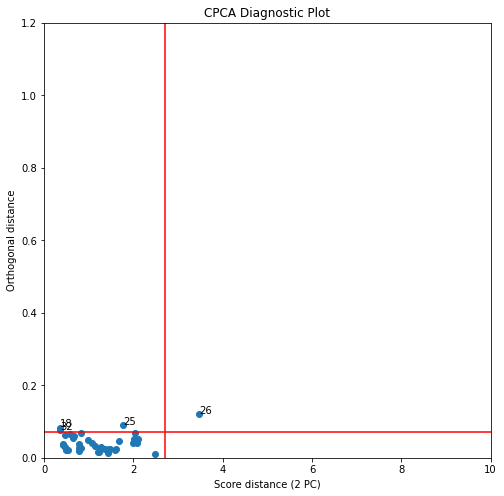

In [89]:
import matplotlib.pyplot as plt
from scipy.stats import chi2

# plotting a line plot after changing it's width and height
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

# calculating cutoff values
cutoff_x = math.sqrt(chi2.isf(df=k0, q=0.025))
plt.axvline(x = cutoff_x, color = 'r', label = 'axvline - full height')

OD = np.array(OD_CPCA).T
OD = OD.reshape(-1,1)
cov = MinCovDet(random_state=42).fit(OD**(2/3))
# print(cov.location_, cov.covariance_[0][0])
cutoff_y = math.pow(cov.location_[0] + math.sqrt(cov.covariance_[0][0]) * 1.96, 3/2)
plt.axhline(y = cutoff_y, color = 'r', label = 'axhline - full width')


plt.scatter(SD_CPCA, OD_CPCA)
for i in range(n):
  if SD_CPCA[i] > cutoff_x or OD_CPCA[i] > cutoff_y:
    plt.text(SD_CPCA[i]+0.002, OD_CPCA[i]+0.002, str(i+1))

# naming the x and y axis
plt.xlabel("Score distance ("+str(k0)+" PC)")
plt.ylabel('Orthogonal distance')
plt.title('CPCA Diagnostic Plot')
plt.xlim(xmin=0, xmax=10)
plt.ylim(ymin=0, ymax=1.2)
plt.show()